In [141]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch
import re
import reciprocalspaceship as rs
import os
import gemmi
import math
import shutil
from sklearn import metrics
import matplotlib.pyplot as plt

In [142]:
import sys
sys.path.append('../valdo/')

In [143]:
from reindex import *
from scaling import Scaler
from blobs import *
from preprocessing import *

##### Define Paths

In [4]:
original_data_path = '../../pipeline/data/original_data/'

In [5]:
basepath = '../../pipeline/'
reindexed_path = basepath + 'data/reindexed/'
scaled_path = basepath + 'data/scaled/'

In [6]:
intersection_path = scaled_path + 'intersection.pkl'
union_path = scaled_path + 'union.pkl'

In [7]:
vae_folder = basepath + 'vae/'
vae_reconstructed_folder = vae_folder + 'reconstructed/'
vae_reconstructed_with_phases_folder = vae_folder + 'reconstructed-phases/'

In [8]:
blob_folder = vae_folder + 'blobs/'

In [9]:
amplitude_col = 'F-obs'
amplitude_scaled_col = 'F-obs-scaled'

error_col = 'SIGF-obs'

In [10]:
recons_col = 'recons'
diff_col = 'diff'
phase_2FOFC_col = 'refine_PH2FOFCWT'
phase_FOFC_col = 'refine_PHFOFCWT'

### Naming Convention (all `id.ext`)

Re-naming Files Template Code: change `source_folder`, `destination_folder`, and extensions.

In [64]:
# Define the source and destination folders
source_folder = "../../PTP1B_DK/all_bound_models_reindexed/"
destination_folder = "../../pipeline/data/bound_models/"

# Get a list of all files in the source folder
file_list = os.listdir(source_folder)

# Define a regular expression pattern to match the filenames
pattern = r".*(\d{4}).*.pdb"

# Iterate over each file in the source folder
for filename in file_list:

    # Check if the file matches the pattern
    match = re.match(pattern, filename)
    if match:
        # Extract the ID from the filename
        id = match.group(1)
        
        # Define the new filename
        new_filename = id + ".pdb"
        
        # Construct the full source and destination paths
        source_path = os.path.join(source_folder, filename)
        destination_path = os.path.join(destination_folder, new_filename)
        
        # Copy the file to the destination folder with the new name
        shutil.copy(source_path, destination_path)

### Reindexing

In [45]:
# List of files to be reindexed

file_list = glob.glob(original_data_path + "*mtz")
file_list.sort()

In [46]:
# Reindexes a list of input MTZ files to a reference MTZ file using gemmi

reindex_files(input_files=file_list, 
              reference_file=file_list[0], 
              output_folder=reindexed_path,
              columns=[amplitude_col, error_col])

100%|██████████| 1680/1680 [17:50<00:00,  1.57it/s]


### Scaling

In [47]:
file_list = glob.glob(reindexed_path + "*mtz")
file_list.sort()

In [48]:
# Initiate the Scaler, file_list[0] serves as the reference

scaler = Scaler(reference_mtz=file_list[0])

In [49]:
# Scales all datasets to the previously provided reference, writes a `metrics.pkl`

metrics = scaler.batch_scaling(mtz_path_list=file_list, 
                               outputmtz_path=scaled_path, 
                               verbose=False)

/n/holyscratch01/hekstra_lab/phyllis/drug-screening/notebooks/../valdo/scaling.py:73: RuntimeWarning: overflow encountered in exp
  FB_scaled = np.exp(ln_k) * np.exp(-args) * FB
/n/holyscratch01/hekstra_lab/phyllis/drug-screening/notebooks/../valdo/scaling.py:73: RuntimeWarning: invalid value encountered in multiply
  FB_scaled = np.exp(ln_k) * np.exp(-args) * FB
/n/holyscratch01/hekstra_lab/phyllis/drug-screening/notebooks/../valdo/scaling.py:73: RuntimeWarning: overflow encountered in exp
  FB_scaled = np.exp(ln_k) * np.exp(-args) * FB
/n/holyscratch01/hekstra_lab/phyllis/drug-screening/notebooks/../valdo/scaling.py:73: RuntimeWarning: invalid value encountered in multiply
  FB_scaled = np.exp(ln_k) * np.exp(-args) * FB


### VAE IO Generation

In [50]:
# Identify all scaled files to use as input and output for the VAE

file_list = glob.glob(scaled_path + "*mtz")
file_list.sort()

##### Remove Samples with Low `end_corr`

In [47]:
metrics_df = pd.read_pickle(scaled_path + "metrics.pkl")

In [48]:
metrics_df.columns=['file', 'start_LS', 'start_corr', 'end_LS', 'end_corr']

In [51]:
metrics_df[metrics_df.isna().any(axis=1)]

,file,start_LS,start_corr,end_LS,end_corr
93,0110,2627835.75,0.995908,NaN,NaN


In [50]:
low_corr_files = list(metrics_df[(metrics_df['end_corr'] < 0.6) | (metrics_df['end_corr'].isnull())]['file'])
low_corr_files = [scaled_path + x + '.mtz' for x in low_corr_files]

In [55]:
file_list = [file for file in file_list if file not in low_corr_files]

##### IO Generation

In [57]:
# Creates an `intersection.mtz` file at the specified path
# This is the intersection of all the scaled files provided

find_intersection(input_files=file_list, 
                  output_path=intersection_path,
                  amplitude_col=amplitude_scaled_col)

100%|██████████| 1612/1612 [00:41<00:00, 39.23it/s]


In [58]:
# Creates an `union.mtz` file at the specified path
# This is the union of all the scaled files provided

find_union(input_files=file_list, 
           output_path=union_path,
           amplitude_col=amplitude_scaled_col)

100%|██████████| 1612/1612 [00:42<00:00, 38.34it/s]


In [59]:
# Generates VAE input and output data from the intersection and union datasets

generate_vae_io(intersection_path=intersection_path, 
                union_path=union_path, 
                io_folder=vae_folder)

/n/home10/phyllis/mambaforge/envs/torch/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3462: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


### VAE Training

In [19]:
# Load the VAE I/O Files Generated

vae_input = np.load(vae_folder + 'vae_input.npy')
vae_output = np.load(vae_folder + 'vae_output.npy')

In [ ]:
# Specify VAE Parameters
latent_dimension = 7

vae = valdo.VAE(n_dim_i = vae_input.shape[1], 
      n_dim_o = vae_output.shape[1], 
      n_dim_latent = latent_dimension, 
      n_hidden_layers = [3, 6], 
      n_hidden_size = 100, 
      activation = torch.relu)

# Randomly select 1300 indices for training
choice = np.random.choice(vae_input.shape[0], 1300, replace=False)    
train_ind = np.zeros(vae_input.shape[0], dtype=bool)
train_ind[choice] = True
test_ind = ~train_ind

# Split the input and output data into training and validation sets
x_train, x_val = vae_input[train_ind], vae_input[test_ind]
y_train, y_val = vae_output[train_ind], vae_output[test_ind]

# Convert the data to torch tensors
x_train, x_val, y_train, y_val = torch.tensor(x_train), torch.tensor(x_val), torch.tensor(y_train), torch.tensor(y_val)

# Set up the optimizer and train the VAE
optimizer = torch.optim.Adam(vae.parameters(), lr=0.001)
vae.train(x_train, y_train, optimizer, x_val, y_val, epochs=300, batch_size=100, w_kl=1.0)

# Save the trained VAE model
vae.save(vae_folder + 'trained_vae.pkl')

In [28]:
# Plot the loss over time

vae = valdo.VAE.load(vae_folder + 'trained_vae.pkl')
loss_array = np.array(vae.loss_train)

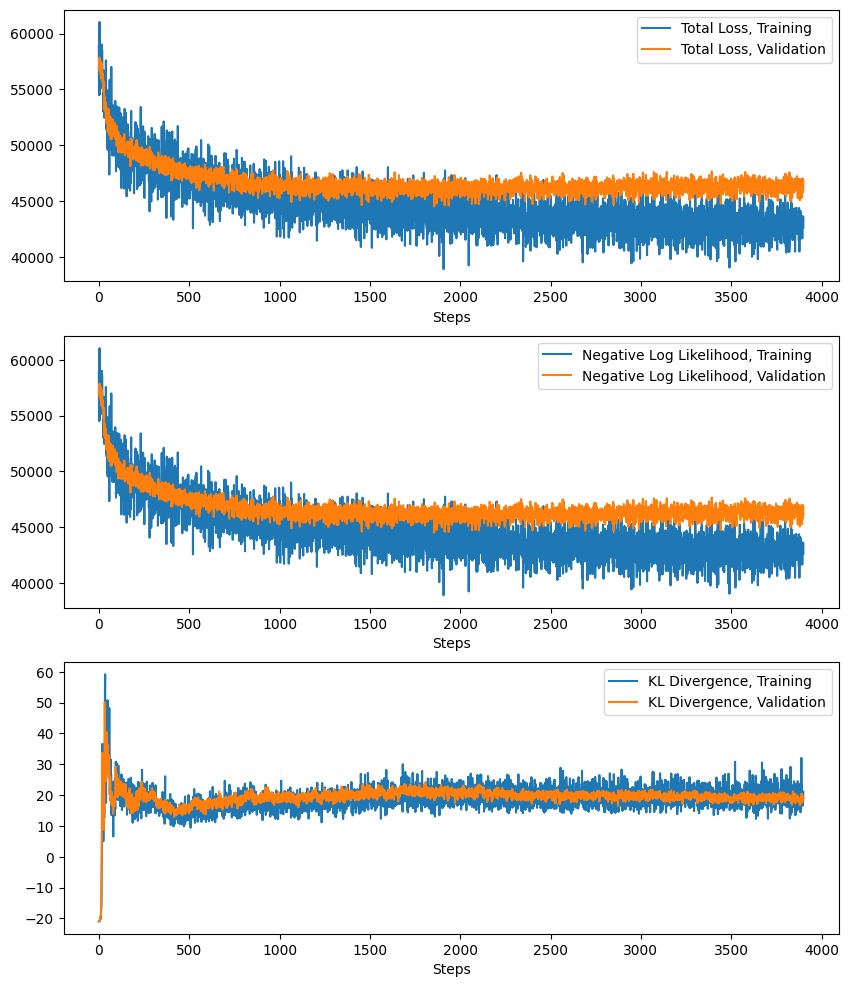

In [31]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=[10,12])
ax = axs.reshape(-1)

ax[0].plot(loss_array[:,0], label='Total Loss, Training')
ax[0].plot(loss_array[:,3], label='Total Loss, Validation')
ax[0].set_xlabel("Steps")
ax[0].legend()

ax[1].plot(loss_array[:,1], label='Negative Log Likelihood, Training')
ax[1].plot(loss_array[:,4], label='Negative Log Likelihood, Validation')
ax[1].set_xlabel("Steps")
ax[1].legend()

ax[2].plot(loss_array[:,2], label='KL Divergence, Training')
ax[2].plot(loss_array[:,5], label='KL Divergence, Validation')
ax[2].set_xlabel("Steps")
ax[2].legend()


plt.show()

### Reconstruction

In [ ]:
# Load trained VAE

vae = valdo.VAE.load(vae_folder + 'trained_vae.pkl')

In [13]:
# Load input file and create a tensor

vae_input = np.load(vae_folder + 'vae_input.npy')
vae_input_tensor = torch.tensor(vae_input)
vae_input_tensor = vae_input_tensor.to("cuda:0")

In [14]:
# Reconstruct the input file via VAE, convert to numpy, and save

recons = vae.reconstruct(torch.tensor(vae_input_tensor))
recons = recons.detach().cpu().numpy()
np.save(vae_reconstructed_folder + 'recons', recons)

/tmp/ipykernel_723023/2661678968.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recons = vae.reconstruct(torch.tensor(vae_input_tensor))


In [61]:
# Re-scale the reconstructed files accordingly and creates the `diff` column
# Function is valdo.preprocessing.rescale

rescale(recons_path=vae_reconstructed_folder + 'recons.npy', 
            intersection_path=intersection_path, 
            union_path=union_path, 
            input_files=file_list, 
            info_folder=vae_folder, 
            output_folder=vae_reconstructed_folder,
            amplitude_col="F-obs-scaled")

100%|██████████| 1612/1612 [04:06<00:00,  6.54it/s]


### Add Phases

In [106]:
# List of reconstructed mtz files without phases to add phases to

file_list = glob.glob(vae_reconstructed_folder + "*mtz")

In [111]:
no_phases_files = []

In [113]:
# Phases here are copied from refinement 

for file in tqdm(file_list):
    
    current = rs.read_mtz(file)
    
    try:
        phases_df = rs.read_mtz('../../pipeline/data/refined_mtzs/'+os.path.basename(file))

    except:
        no_phases_files.append(file)
        continue
    
    current[phase_2FOFC_col] = phases_df['PH2FOFCWT']
    current[phase_FOFC_col] = phases_df['PHFOFCWT']
    
    current.write_mtz(vae_reconstructed_with_phases_folder + os.path.basename(file))

100%|██████████| 1612/1612 [06:29<00:00,  4.14it/s]


### Find Blobs

In [114]:
# List of reconstructed mtz files (with phases) to identify blobs in

file_list = glob.glob(vae_reconstructed_with_phases_folder + "*mtz")

In [ ]:
# Function in valdo.blobs that generates a list of blobs

generate_blobs(input_files=file_list, 
               model_folder='../../pipeline/data/refined_models/', 
               diff_col='diff', 
               phase_col='refine_PH2FOFCWT', 
               output_folder=blob_folder, 
               cutoff=3.5)

### Tagging Blobs

#### Helper Functions

##### Finds Nearby Atoms

In [82]:
def find_nearby_atoms(centroid_dict, structure_path, sample_no=None, radius=3):
    
    """
    Finds nearby atoms within a specified radius around a given centroid position in a structure file and returns the atom details as a DataFrame.

    The function reads the structure file in PDB format using gemmi, performs a neighbor search within the specified radius around the centroid position, and retrieves information about the nearby atoms. The atom details include the sample number, chain name, residue sequence ID, residue name, atom name, element name, coordinates (x, y, z), and distance from the centroid.

    Args:
        centroid_dict (dict): Dictionary containing the centroid position with keys 'x', 'y', and 'z'.
        structure_path (str): Path to the structure file in PDB format.
        sample_no (str): Sample number or identifier. Optional.
        radius (float, optional): Radius in angstroms to search for nearby atoms. Default is 3.

    Returns:
        pandas.DataFrame: DataFrame containing the details of the nearby atoms.

    Example:
        centroid = {'x': 10.0, 'y': 20.0, 'z': 30.0}
        structure_file = './data/structure.pdb'
        sample_number = 'S001'
        nearby_atoms = find_nearby_atoms(centroid, structure_file, sample_number, radius=5)
    """
    
    peaks = []
    
    structure = gemmi.read_pdb(structure_path)
    ns = gemmi.NeighborSearch(structure[0], structure.cell, radius).populate()
    centroid = gemmi.Position(centroid_dict["x"], centroid_dict["y"], centroid_dict["z"])
    marks = ns.find_atoms(centroid)
    
    for mark in marks:
        image_idx = mark.image_idx
        cra = mark.to_cra(structure[0])
        dist = structure.cell.find_nearest_pbc_image(centroid, cra.atom.pos, mark.image_idx).dist()

        record = {
            "sample"  :    sample_no,
            "chain"   :    cra.chain.name,
            "seqid"   :    cra.residue.seqid.num,
            "residue" :    cra.residue.name,
            "atom"    :    cra.atom.name,
            "element" :    cra.atom.element.name,
            "coordx"  :    cra.atom.pos.x,
            "coordy"  :    cra.atom.pos.y,
            "coordz"  :    cra.atom.pos.z,
            "dist"    :    dist
        }

        peaks.append(record)
        
    return pd.DataFrame(peaks)

##### Tag Blobs near Cys215

In [144]:
def tag_cys_215_blobs(df, structure_path, radius=3):
    
    """
    Tags the blobs in the DataFrame 'df' that contain the CYS 215 residue based on the nearby atoms found in PDB files.

    Args:
        df (pandas.DataFrame): The input DataFrame containing the blobs information.
        structure_path (str): The path to the folder containing the PDB files used for identifying nearby atoms.
        radius (int, optional): The radius in Angstroms for finding nearby atoms. Default is 3.

    Returns:
        pandas.DataFrame: The modified DataFrame with an additional 'cys215' column indicating the presence (1) or absence (0) of CYS 215 in the blobs.
    """
    
    def check_blob_for_cys(row):
        
        """
        Args:
            row (pandas.Series): A row of the DataFrame representing a blob.

        Returns:
            int: Returns 1 if the blob contains CYS 215, otherwise returns 0.
        """
        
        sample = row["sample"]
        
        cenx, ceny, cenz = row['cenx'], row['ceny'], row['cenz']
        atoms_df = find_nearby_atoms({"x": cenx, "y": ceny, "z": cenz}, structure_path + sample + '.pdb', sample, radius)
        
        if len(atoms_df) < 1:
            return 0
        
        if 215 in set(atoms_df['seqid']):
            return 1
        return 0
    
    tqdm.pandas()
    df['cys215'] = df.progress_apply(check_blob_for_cys, axis=1)
    
    return df

##### Tag Blobs near LIG Atoms

In [164]:
def tag_lig_blobs(df, structure_path):
    
    """
    Tags the blobs in the DataFrame 'df' that contain ligands based on the nearby atoms found in PDB files.

    Args:
        df (pandas.DataFrame): The input DataFrame containing the blobs information.
        structure_path (str): The path to the folder containing the PDB files used for identifying nearby atoms.

    Returns:
        pandas.DataFrame: The modified DataFrame with an additional 'ligand' column indicating the presence (1) or absence (0) of ligands in the blobs.

    """
    def check_blob_for_lig(row):
        
        """
        Args:
            row (pandas.Series): A row of the DataFrame representing a blob.

        Returns:
            int: Returns 1 if the blob contains ligands, otherwise returns 0.

        """
        
        if row["bound"] == 0:
            return 0
        
        sample = row["sample"]
        
        cenx, ceny, cenz = row['cenx'], row['ceny'], row['cenz']
        atoms_df = find_nearby_atoms({"x": cenx, "y": ceny, "z": cenz}, structure_path + sample + '.pdb', sample, row['radius'])

        if len(atoms_df) < 1:
            return 0
        
        if 'LIG' in set(atoms_df['residue']):
            return 1
        return 0
    
    tqdm.pandas()
    df['ligand'] = df.progress_apply(check_blob_for_lig, axis=1)
    
    return df

##### Validate Fractional Coordinates

In [165]:
def valid_fractional_coords(coords):
    
    """
    Converts fractional coordinates to valid fractional coordinates within the range [0, 1).

    Args:
        coords (list or numpy.ndarray): The input fractional coordinates.

    Returns:
        numpy.ndarray: The converted valid fractional coordinates within the range [0, 1).

    """
    
    valid_coords = np.array(coords)
    for i in range(3):
        while valid_coords[i] > 1:
            valid_coords[i] -= 1
        while valid_coords[i] < 0:
            valid_coords[i] += 1
    return valid_coords

##### Determine Locations

In [166]:
# Function to fractionalize coordinates and find all symmetry-related cartesian points 

def determine_locations(row, folder):
    
    """
    Converts coordinates to fractional form and determines all symmetry-related cartesian points for the given row.

    Args:
        row (pandas.Series): A row of the DataFrame representing a blob.
        folder (str): The path to the folder containing the mtz files.

    Returns:
        pandas.Series: A pandas Series containing the fractional coordinates, all possible fractional coordinates, and all possible cartesian coordinates.

    """
    
    # find mtz file for sample number
    mtz_file = folder + row['sample'] + '.mtz'
    if mtz_file is None:
        return pd.Series({'fractional': np.nan, 'all_possible_frac': np.nan, 'all_possible_cart': np.nan})
    
    # read in mtz file
    sample_file = rs.read_mtz(mtz_file)
    
    # fractionalize coordinates using move2cell
    frac_coords = move2cell([row['cenx'], row['ceny'], row['cenz']], sample_file.cell)
    
    # identify all symmetry operations
    all_ops = list(sample_file.spacegroup.operations().sym_ops)

    all_possible_frac = []
    for op in all_ops:
        result = op.apply_to_xyz(frac_coords)
        result = valid_fractional_coords(result)
        all_possible_frac.append(result)
        
    all_possible_frac = sorted(all_possible_frac, key=lambda x: x[0])
                
    # orthogonalize fractional coordinates
    all_possible_cart = [sample_file.cell.orthogonalize(gemmi.Fractional(*elt)) for elt in all_possible_frac]
    
    all_possible_cart = [np.array([elt.x, elt.y, elt.z]) for elt in all_possible_cart]
    
    return pd.Series({'fractional': frac_coords, 'all_possible_frac': all_possible_frac, 'all_possible_cart': all_possible_cart})

##### Move Points to the Unit Cell

In [167]:
def move2cell(cartesian_coordinates, unit_cell, fractionalize=True):
    
    '''
    Move your points into a unitcell with translational vectors
    
    Parameters
    ----------
    cartesian_coordinates: array-like
        [N_points, 3], cartesian positions of points you want to move
        
    unit_cell, gemmi.UnitCell
        A gemmi unitcell instance
    
    fractionalize: boolean, default True
        If True, output coordinates will be fractional; Or will be cartesians
    
    Returns
    -------
    array-like, coordinates inside the unitcell
    '''
    o2f_matrix = np.array(unit_cell.fractionalization_matrix)
    frac_pos = np.dot(cartesian_coordinates, o2f_matrix.T) 
    frac_pos_incell = frac_pos % 1
    for i in range(len(frac_pos_incell)):
        if frac_pos_incell[i] < 0:
            frac_pos_incell[i] += 1
    if fractionalize:
        return frac_pos_incell
    else:
        f2o_matrix = np.array(unit_cell.orthogonalization_matrix)
        return np.dot(frac_pos_incell, f2o_matrix.T)

##### Remove Duplicate Blobs

In [170]:
def mark_duplicates(blobs_df):
    
    """
    Marks duplicate blobs in the DataFrame based on proximity in cartesian coordinates. 
    Checks on a per-sample basis, checking blobs with adjacent peak values.

    Args:
        blobs_df (pandas.DataFrame): The input DataFrame containing the blob information.

    Returns:
        pandas.DataFrame: The modified DataFrame with an additional 'duplicate' column indicating duplicate blobs.

    """
    
    blobs_df = blobs_df.sort_values(by='peak', ascending=False)
    blobs_df['duplicate'] = 0  # Initialize 'duplicate' column with 0
    
    def check_euclidean_distance(list1, list2):
        
        """
        Checks if the distance between any pairwise points in two lists is less than 1.

        Args:
            list1 (list): The first list of cartesian coordinates.
            list2 (list): The second list of cartesian coordinates.

        Returns:
            bool: Returns True if any distance is less than 1, otherwise returns False.

        """
        
        for point1 in list1:
            for point2 in list2:
                distance = math.sqrt((point2[0] - point1[0])**2 + (point2[1] - point1[1])**2 + (point2[2] - point1[2])**2)
                if distance < 1:
                    return True
        return False
    
    grouped = blobs_df.groupby('sample')
    
    for _, group in grouped:
        if len(group) > 1:
            all_possible_cart_lists = group['all_possible_cart'].tolist()
            for i in range(1, len(all_possible_cart_lists)):
                if check_euclidean_distance(all_possible_cart_lists[i-1], all_possible_cart_lists[i]):
                    blobs_df.at[group.index[i], 'duplicate'] = 1
    
    return blobs_df

#### Tagging Blobs

In [171]:
blob_df = pd.read_pickle(blob_folder + 'blob_stats.pkl')

Tag Samples that are Bound (1 if bound, 0 otherwise)

In [172]:
with open("../../bound_sample_ids.txt") as f:
    bound_samples = set([line.strip() for line in f])

# Set the "bound" column based on whether or not each sample is in the bound samples list
blob_df["bound"] = blob_df["sample"].apply(lambda x: 1 if x in bound_samples else 0)

Tag Samples within 3A of a Cys215 Atom (1 if within, 0 otherwise)

In [173]:
blob_df = tag_cys_215_blobs(blob_df, '../../pipeline/data/refined_models/')

100%|██████████| 10580/10580 [00:38<00:00, 275.99it/s]


Tag Samples within `r` of a known LIG atom (1 if yes, 0 otherwise)

In [174]:
blob_df = tag_lig_blobs(blob_df, '../../pipeline/data/bound_models/')

100%|██████████| 10580/10580 [00:02<00:00, 3984.84it/s]


Tag Blobs that are Duplicates of Other Blobs (Patch for Gemmi's ASU Mask Issue)

In [175]:
# Identifies all possible cartesian coordinates after symmetry operations
blobs_df[['fractional', 'all_possible_frac', 'all_possible_cart']] = blobs_df.apply(determine_locations, args=('../../pipeline/vae/reconstructed-phases/',), axis=1)

In [176]:
# Marks blobs as duplicates if they are within 1A of another blob in the same sample
blobs_df = mark_duplicates(blobs_df)

Tag Blobs Belonging to Samples with High R Factors

In [177]:
# In this case, no blobs are removed

r_factors = pd.read_csv('../../pipeline/data/refine_stats.csv')[['data_id', 'Rfree_final']]
high_r_factors = r_factors.loc[r_factors['Rfree_final'] > 0.4, 'data_id'].astype(str).str.zfill(4)
blobs_df['high_r_factor'] = blobs_df['sample'].isin(list(high_r_factors))

In [178]:
blobs_df.to_pickle('../../pipeline/vae/blobs/blob_stats_tagged.pkl')

Filter Blobs (Remove Cys215, High R Factor, Duplicates, and more)

In [179]:
blobs_df = pd.read_pickle('../../pipeline/vae/blobs/blob_stats_tagged.pkl')

In [180]:
# Remove all samples where Helen Ginn does not include a bound state model
# In this case, there are no blobs

hg_no_lig = ['0060', '1429', '1733', '1791', '0225', '0432', '0710']
blobs_df = blobs_df[~blobs_df['sample'].isin(hg_no_lig)] 

In [181]:
# Remove Cys215 related blobs, blobs in samples with high R factors, and duplicates

blobs_df = blobs_df[(blobs_df['cys215']==0) & (blobs_df['high_r_factor']==0) & (blobs_df['duplicate']==0)]    

In [182]:
blobs_df.to_pickle('../../pipeline/vae/blobs/filtered_blob_stats_tagged.pkl')

### Generate AUC Curve

In [183]:
def plot_roc_blob_stats(path, name=''):
    
    blob_df = pd.read_pickle(path)
    
    # create ROC curve
    fpr, tpr, thresholds = metrics.roc_curve(blob_df["ligand"], blob_df["score"], pos_label=1)
    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=name)
    display.plot()
    
    print("Total Number of Blobs:", len(blob_df))
    print("Total Number of Unique Samples:", len(blob_df.drop_duplicates(subset='sample')))
    
    plt.savefig(os.path.dirname(path) + '/roc_curve.pdf')

Total Number of Blobs: 9186
Total Number of Unique Samples: 1504


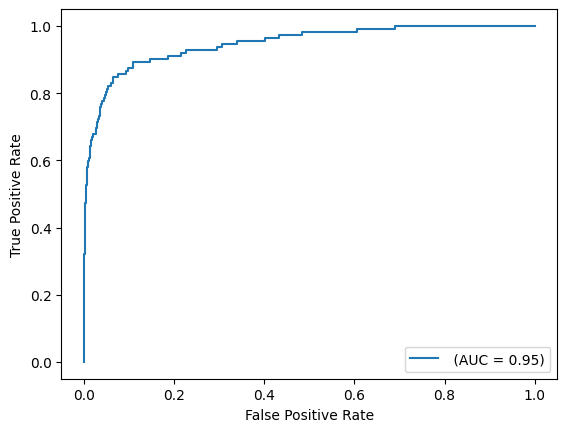

In [184]:
plot_roc_blob_stats('../../pipeline/vae/blobs/filtered_blob_stats_tagged.pkl')

In [185]:
pd.read_pickle('../../pipeline/vae/blobs/filtered_blob_stats_tagged.pkl')

,sample,peakz,peak,score,cenx,ceny,cenz,volume,radius,bound,cys215,ligand,fractional,all_possible_frac,all_possible_cart,duplicate,high_r_factor
2886,1157,30.587446,30.587446,2136.145745,-4.242925,50.633543,14.472170,266.325369,3.991241,0,0,0,"[0.2766348699576954, 0.6472052310051913, 0.135...","[[0.2766348699576954, 0.6472052310051913, 0.13...","[[-4.242925229289646, 50.63354264594023, 14.47...",0,False
1292,1271,24.405131,24.405134,4445.678079,7.621010,46.211370,7.276030,604.592523,5.245554,1,0,1,"[0.38234320964125046, 0.5947888650530466, 0.06...","[[0.21244565541179616, 0.6176567903587495, 0.7...","[[-8.646784732768765, 47.98806425710261, 78.18...",0,False
5127,1608,23.689568,23.689568,5243.059679,24.936777,19.344661,15.607581,652.928797,5.381777,1,0,1,"[0.40168908947997056, 0.24851242629973846, 0.1...","[[0.15317666318023213, 0.7514875737002615, 0.5...","[[-20.005223343945154, 58.49716600053162, 55.5...",0,False
423,1618,22.986976,22.986979,4355.449126,24.231063,19.268108,15.279841,542.319248,5.058893,1,0,1,"[0.3937840837358257, 0.24780467276421117, 0.14...","[[0.1459794109716145, 0.7521953272357889, 0.52...","[[-20.660937195593586, 58.48711680288205, 55.6...",0,False
2887,1157,22.947004,22.947004,1153.193546,8.467796,51.131652,22.937902,157.083359,3.347191,0,0,0,"[0.420521699182933, 0.6535721389899432, 0.2148...","[[0.2330504398070102, 0.579478300817067, 0.881...","[[-5.121088049609796, 45.334984717672334, 94.1...",0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6249,0368,3.663437,3.663437,37.121902,8.262830,57.059508,33.518703,10.419012,1.354917,0,0,0,"[0.45749538385679306, 0.7315129981354819, 0.31...","[[0.2684870018645181, 0.7259823857213112, 0.64...","[[-8.51189797883109, 56.62810861014468, 69.111...",0,False
3233,1462,3.662832,3.662832,39.145507,1.346083,49.490488,15.966678,10.999330,1.379619,0,0,0,"[0.32950187616310184, 0.6293550036133903, 0.14...","[[0.2998531274502884, 0.6704981238368981, 0.81...","[[-3.2140216415779115, 52.72585282249315, 87.6...",0,False
9901,0719,3.653957,3.653957,46.535807,6.863989,43.662181,31.040419,13.079756,1.461629,0,0,0,"[0.3555299953561279, 0.5588819852771604, 0.289...","[[0.20335198992103254, 0.644470004643872, 0.95...","[[-10.724436548685489, 50.34867239303988, 102....",0,False
4147,1953,3.652959,3.652959,38.738740,3.393518,49.145936,0.990260,10.827288,1.372388,0,0,0,"[0.35356241916019954, 0.6315882817667232, 0.00...","[[0.27802586260652373, 0.6464375808398004, 0.6...","[[-4.060629756959678, 50.301408153461885, 71.8...",0,False
